In [1]:
import pystan
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set(rc={'figure.figsize':(14, 10)})

In [3]:
df = pd.read_csv('data/evaluation_sleepstudy.csv', index_col=0)

In [4]:
df['Subject_id'] = LabelEncoder().fit_transform(df.Subject.values)+1

In [5]:
df

,Reaction,Days,Subject,Subject_id
1,249.5600,0,308,1
2,258.7047,1,308,1
3,250.8006,2,308,1
4,321.4398,3,308,1
5,356.8519,4,308,1
...,...,...,...,...
176,329.6076,5,372,18
177,334.4818,6,372,18
178,343.2199,7,372,18
179,369.1417,8,372,18


<AxesSubplot:xlabel='Days', ylabel='Reaction'>

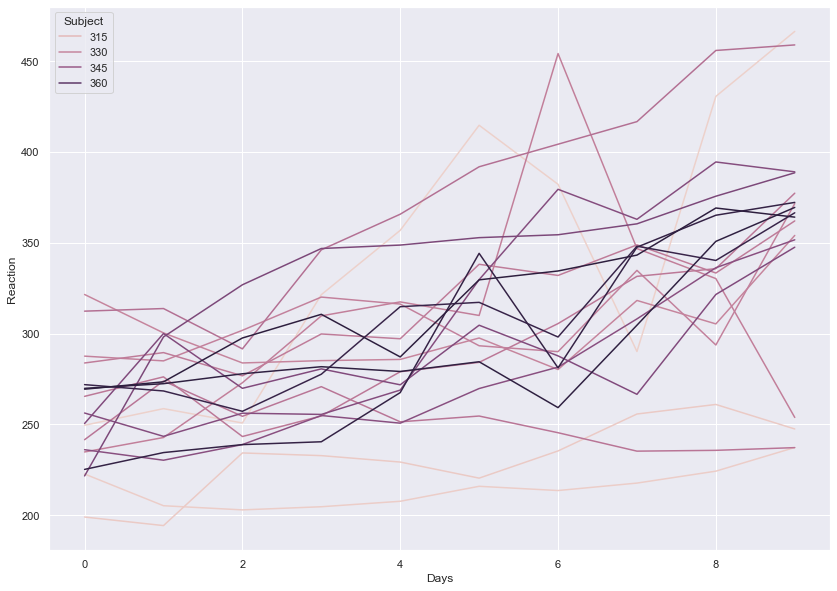

In [6]:
sns.lineplot(data=df, x='Days', y='Reaction', hue='Subject')

In [7]:
data = {'N': df.shape[0], 'reactions': df.Reaction.values, 'days': df.Days.values}

## 17.2.1

In [8]:
ocode = '''
data {
    int<lower=0> N;
    vector[N] reactions;
    vector[N] days;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    alpha ~ normal(0, 250);
    beta ~ normal(0, 250);
    sigma ~ normal(0, 50);
    
    for (i in 1:N) 
        reactions[i] ~ normal(alpha+days[i]*beta, sigma);
}
'''
sm_homo = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_30410217cc983ee9e43387e4edab2cee NOW.


In [9]:
fit_homo = sm_homo.sampling(data=data, iter=1000, chains=4, seed=1)
fit_homo

Inference for Stan model: anon_model_30410217cc983ee9e43387e4edab2cee.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha 251.07    0.24   6.67 237.22 246.92 250.98 255.46 263.45    761    1.0
beta    10.5    0.05   1.27   8.11   9.69  10.48   11.3  13.09    708    1.0
sigma  47.97    0.07   2.69  42.95  46.11  47.84  49.68  53.73   1287    1.0
lp__  -783.4    0.05   1.35 -786.8 -783.9 -783.0 -782.4 -781.9    771    1.0

Samples were drawn using NUTS at Fri May 14 23:17:49 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## 17.2.2

Text(0, 0.5, 'beta')

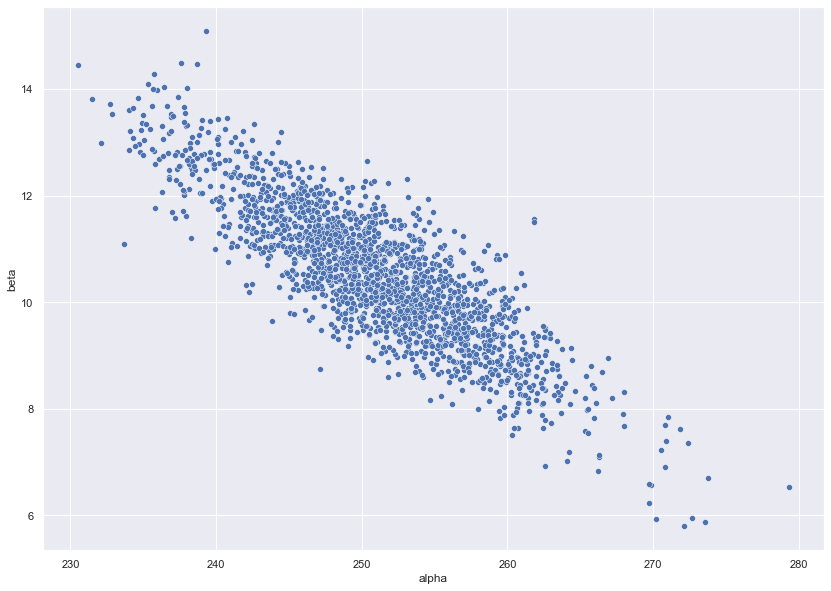

In [10]:
sns.scatterplot(x=fit_homo.extract('alpha')['alpha'], y=fit_homo.extract('beta')['beta'])
plt.xlabel('alpha')
plt.ylabel('beta')

## 17.2.3

In [11]:
ocode = '''
data {
    int<lower=0> N;
    vector[N] reactions;
    vector[N] days;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    alpha ~ normal(0, 250);
    beta ~ normal(0, 250);
    sigma ~ normal(0, 50);
    
    for (i in 1:N) 
        reactions[i] ~ normal(alpha+days[i]*beta, sigma);
}

generated quantities {
    vector[10] gen_reactions;
    for (i in 1:10) 
        gen_reactions[i] = normal_rng(alpha+i*beta, sigma);
}
'''
sm_homo_gen = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_847a5f60a35d53109425cb221129367d NOW.


In [12]:
fit_homo_gen = sm_homo_gen.sampling(data=data, iter=1000, chains=4, seed=1)
fit_homo_gen

Inference for Stan model: anon_model_847a5f60a35d53109425cb221129367d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha              251.0    0.26   6.48 238.63 246.49 251.04 255.05 264.28    639    1.0
beta               10.54    0.05    1.2   8.14   9.78  10.53  11.34  12.84    670    1.0
sigma              47.89    0.07   2.54  43.09  46.12  47.77  49.54  53.13   1171    1.0
gen_reactions[1]  261.47    1.07  46.95 169.92 228.87 261.67 291.45 358.46   1922    1.0
gen_reactions[2]   271.3    1.04  47.02 176.54 237.55 271.67 304.02 360.22   2042    1.0
gen_reactions[3]   280.2    1.13  48.42 185.37 247.52 281.47 313.38 375.07   1823    1.0
gen_reactions[4]  294.89     1.1  47.48 201.75 261.61 293.19 326.85 386.91   1861    1.0
gen_reactions[5]  303.77    1.17  48.43  205.4 272.15 303.85 335.76 398.79   1719    1.0
gen_reaction

<AxesSubplot:xlabel='Days', ylabel='Reaction'>

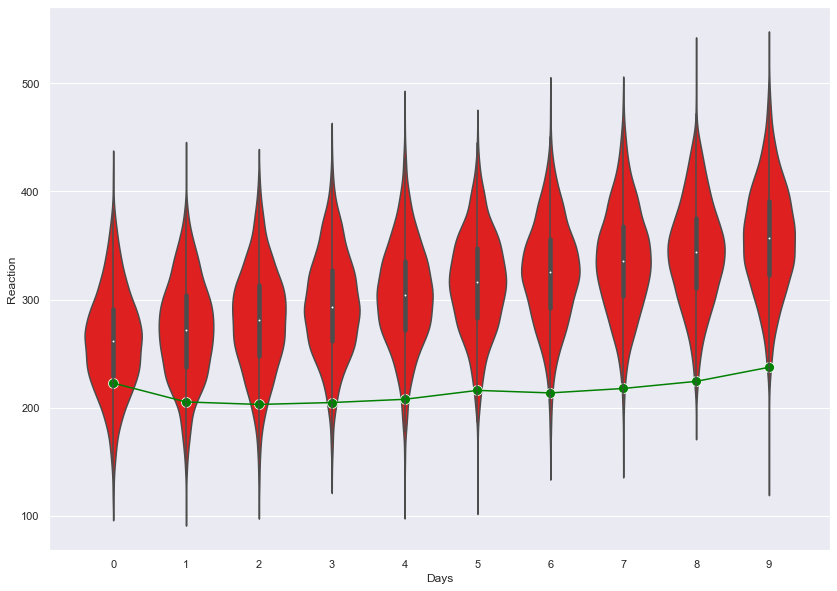

In [13]:
sns.violinplot(data=list(fit_homo_gen.extract('gen_reactions')['gen_reactions'].T), color='red')
df1 = df[df.Subject == 309]
sns.lineplot(data=df1, x='Days', y='Reaction', color='green')
sns.scatterplot(data=df1, x='Days', y='Reaction', s=100, color='green')

## 17.2.4

In [14]:
ocode = '''
data {
    int<lower=0> N;
    vector[N] reactions;
    vector[N] days;
    int N_patients;
    int patients_id[N];
}

parameters {
    real alpha[N_patients];
    real beta[N_patients];
    real<lower=0> sigma;
}

model {
    alpha ~ normal(0, 250);
    beta ~ normal(0, 250);
    sigma ~ normal(0, 50);
    
    for (i in 1:N)
        reactions[i] ~ normal(alpha[patients_id[i]]+days[i]*beta[patients_id[i]], sigma);
}

'''
sm_hetero = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9df217f04e96504d30a8e5eba9698bc6 NOW.


In [15]:
data2 = {'patients_id': df.Subject_id.values, 'N_patients': 18, **data}

In [16]:
fit_hetero = sm_hetero.sampling(data=data2, iter=1000, chains=4, seed=1)
fit_hetero

Inference for Stan model: anon_model_9df217f04e96504d30a8e5eba9698bc6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]  244.01     0.3  15.08 213.86 234.03 244.22 254.34 273.96   2447    1.0
alpha[2]   204.3    0.34  15.14 173.92 194.09 204.42 214.57 233.95   1941    1.0
alpha[3]  202.99    0.35  15.21 171.98 193.13 203.05 212.89 233.45   1852    1.0
alpha[4]  288.98    0.32  15.05  260.0 278.59 288.84  299.2 319.02   2179    1.0
alpha[5]  284.79    0.31  14.76 256.16 274.81 284.72 294.71 314.74   2220    1.0
alpha[6]  263.53    0.31  14.82 233.92 253.68 263.76 273.56 292.23   2332    1.0
alpha[7]  273.97    0.34  15.67 243.73 263.27 274.25 284.58 304.17   2135    1.0
alpha[8]  239.51    0.31  15.18 209.84 229.83 239.84 249.76 269.85   2362    1.0
alpha[9]  261.86    0.31  15.28 232.82 251.63 261.97 271.89 292.68   2393    1.0
alp

## 17.2.5

<AxesSubplot:ylabel='Count'>

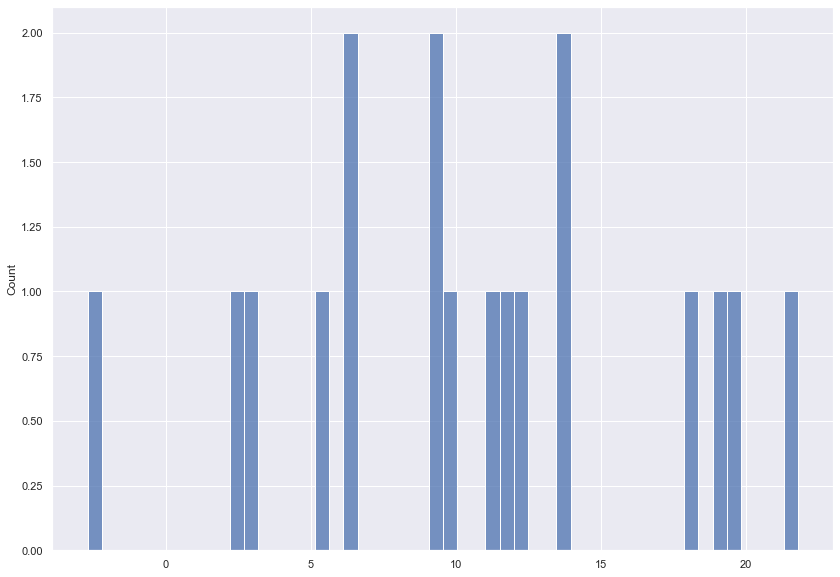

In [17]:
sns.histplot(fit_hetero.extract('beta')['beta'].mean(axis=0), bins=50)

In [18]:
fit_hetero.extract('beta')['beta'].mean()

10.586433779153433

## 17.2.6

In [19]:
ocode = '''
data {
    int<lower=0> N;
    vector[N] reactions;
    vector[N] days;
    int N_patients;
    int patients_id[N];
}

parameters {
    real alpha[N_patients];
    real beta[N_patients];
    real<lower=0> sigma;
}

model {
    alpha ~ normal(0, 250);
    beta ~ normal(0, 250);
    sigma ~ normal(0, 50);
    
    for (i in 1:N)
        reactions[i] ~ normal(alpha[patients_id[i]]+days[i]*beta[patients_id[i]], sigma);
}

generated quantities {
    vector[N] gen_reactions;
    for (i in 1:N)
        gen_reactions[i] = normal_rng(alpha[patients_id[i]]+days[i]*beta[patients_id[i]], sigma);
}
'''
sm_hetero_gen = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f968631eb3aeac57ceeadf314f99646 NOW.


In [20]:
fit_hetero_gen = sm_hetero_gen.sampling(data=data2, iter=1000, chains=4, seed=1)
fit_hetero_gen


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_0f968631eb3aeac57ceeadf314f99646.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]          243.08    0.31  14.74 215.42 233.42 242.98 252.74 272.86   2243    1.0
alpha[2]           204.4    0.34  15.56 173.01 194.13 204.62 214.97 234.97   2139    1.0
alpha[3]          202.83    0.32  15.19 172.57 192.37 202.87  213.6 231.76   2193    1.0
alpha[4]          288.73    0.31  15.31 257.93 277.91 288.97 299.18 318.98   2452    1.0
alpha[5]          284.71    0.29  15.22 254.99 274.22 284.76 294.43 314.96   2849    1.0
alpha[6]          263.14    0.31  15.49 234.03 253.25 263.37 273.27  292.5   2566    1.0
alpha[7]          273.98    0.29   14.8 244.87 263.74 274.03 283.95 303.45   2674    1.0
alpha[8]          239.15    0.29  14.58 210.42 229.69 238.97 

In [21]:
fit_hetero_gen.extract('gen_reactions')['gen_reactions'].shape

(2000, 180)

In [22]:
def plot_for_i(fit, patient_id, df, gen_name='gen_reactions'):
    mask = df.Subject_id == patient_id
    sns.violinplot(data=list(fit.extract(gen_name)[gen_name][:,mask].T), color='red')
    df1 = df[mask]
    sns.lineplot(data=df1, x='Days', y='Reaction', color='green')
    sns.scatterplot(data=df1, x='Days', y='Reaction', s=100, color='green')

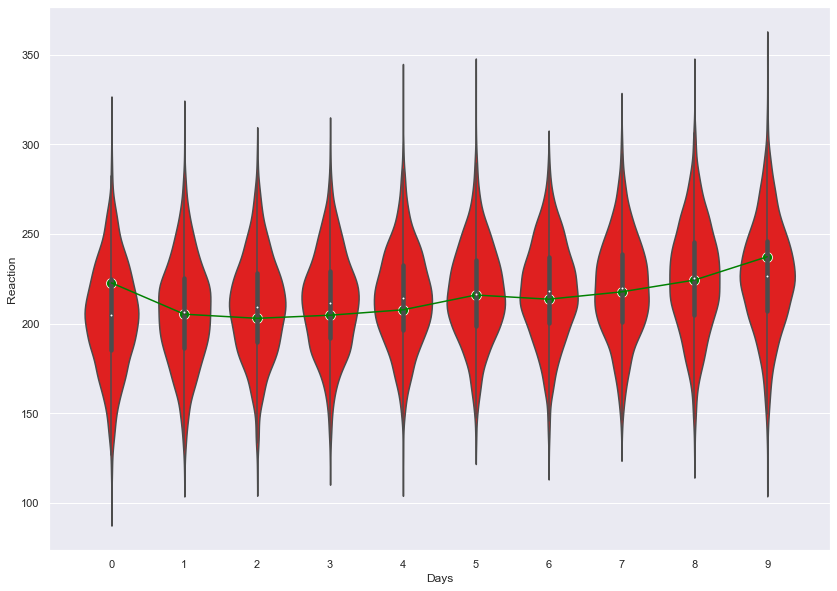

In [23]:
plot_for_i(fit_hetero_gen, 2, df)

## 17.2.7

### Homogenous model

Homogenous model is the same, only train data is different.

In [24]:
df_train = df[df.Subject_id < 18]
df_test = df[df.Subject_id == 18]

In [25]:
data_test = {'N': df_train.shape[0], 'reactions': df_train.Reaction.values, 'days': df_train.Days.values}

In [26]:
fit_homo_test = sm_homo_gen.sampling(data=data_test, iter=1000, chains=4, seed=1)
fit_homo_test

Inference for Stan model: anon_model_847a5f60a35d53109425cb221129367d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha             249.99    0.22   6.93 236.36 245.39 249.79  254.6 263.76    971    1.0
beta               10.53    0.04    1.3    8.0   9.64  10.53  11.38  13.02   1028    1.0
sigma              49.03    0.08    2.7  44.19  47.06  48.96  50.77  54.81   1049    1.0
gen_reactions[1]  261.08    1.14  48.78 162.99 229.06 261.67 292.18 356.31   1821    1.0
gen_reactions[2]  270.52    1.15  50.09 173.21 235.16 270.56 304.56 370.11   1909    1.0
gen_reactions[3]  280.99     1.1  48.82 183.71 248.08 280.32 313.24 375.66   1976    1.0
gen_reactions[4]  291.61    1.15  49.41 198.37  257.9 291.72 325.03 388.43   1849    1.0
gen_reactions[5]  300.93    1.13  48.12 203.93  268.5 301.52 334.26 395.24   1827    1.0
gen_reaction

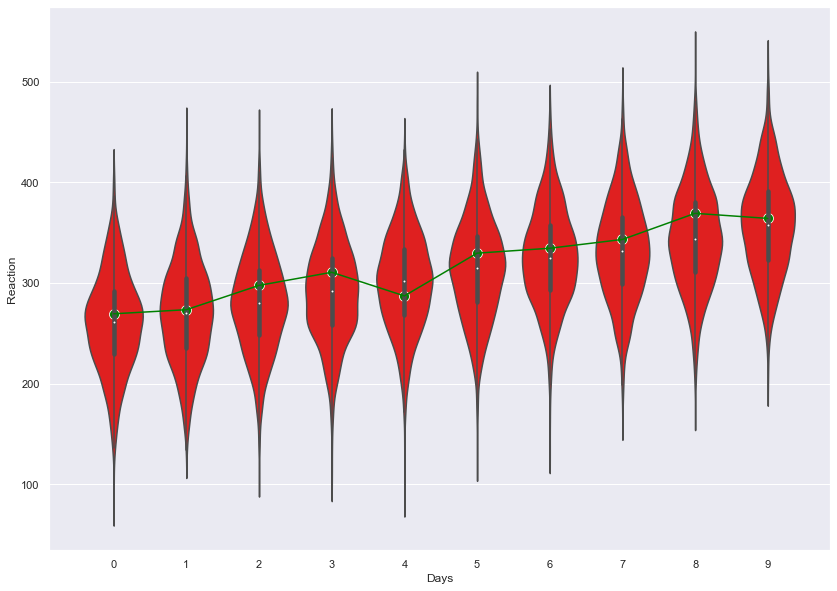

In [27]:
plot_for_i(fit_homo_test, 18, df_test)

### Heterogenous model

For this we cannot estimate parameter for patient, so use default priors.

In [28]:
ocode = '''
data {
    int<lower=0> N;
    vector[N] reactions;
    vector[N] days;
    int N_patients;
    int patients_id[N];
    
    int<lower=0> N_test;
    vector[N_test] days_test;
}

parameters {
    real alpha[N_patients];
    real beta[N_patients];
    real<lower=0> sigma;
}

model {
    alpha ~ normal(0, 250);
    beta ~ normal(0, 250);
    sigma ~ normal(0, 50);
    
    for (i in 1:N)
        reactions[i] ~ normal(alpha[patients_id[i]]+days[i]*beta[patients_id[i]], sigma);
}

generated quantities {
    vector[N_test] gen_test;
    real alphaTest;
    real betaTest;
    alphaTest = normal_rng(0, 250);
    betaTest = normal_rng(0, 250);
    
    for (i in 1:N_test)
        gen_test[i] = normal_rng(alphaTest+days_test[i]*betaTest, sigma);
}
'''
sm_hetero_test = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80ff90ae6d0dc2b8db54b4e920af74c3 NOW.


In [29]:
data_test_hetero = {**data_test, 'N_patients':17, 'patients_id':df_train.Subject_id.values, 'N_test': df_test.Days.shape[0], 'days_test': df_test.Days.values, }

In [30]:
fit_hetero_18_test = sm_hetero_test.sampling(data=data_test_hetero, iter=1000, chains=4, seed=1)
fit_hetero_18_test

Inference for Stan model: anon_model_80ff90ae6d0dc2b8db54b4e920af74c3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]     243.77    0.31  15.73 212.01 233.37 243.91 254.17 275.14   2642    1.0
alpha[2]     204.07    0.31  15.41 175.19 193.75 204.18 214.64 234.49   2433    1.0
alpha[3]     202.44     0.3  15.61  172.1  192.1 202.45 212.65 233.86   2778    1.0
alpha[4]     288.48    0.27  15.74 258.01 277.43 288.95  299.0 318.99   3417    1.0
alpha[5]     284.35    0.28  15.36 255.03 273.92 284.44 295.27  313.8   3052    1.0
alpha[6]     263.31    0.34  16.22  231.9 251.63 263.45 273.83 296.08   2332    1.0
alpha[7]      273.9     0.3   15.8 242.83 263.21 274.22 283.95 305.23   2861    1.0
alpha[8]     239.36    0.29  15.25 208.67 229.28 239.42 249.39 269.32   2794    1.0
alpha[9]     261.71    0.29  15.27 231.65 251.18 261.74  

(-1000.0, 1000.0)

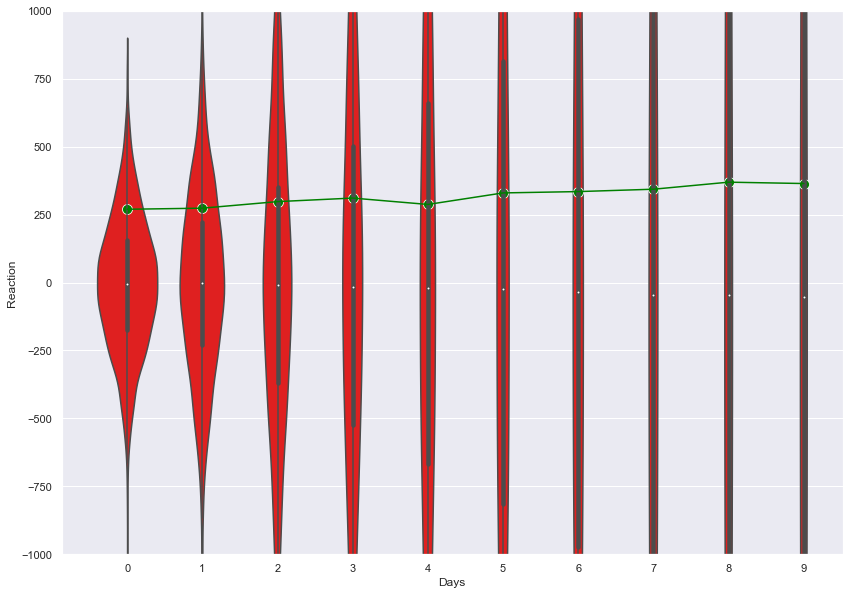

In [31]:
plot_for_i(fit_hetero_18_test, 18, df_test, 'gen_test')
plt.ylim((-1000,1000))

## 17.2.8

In [32]:
ocode = '''
data {
    int<lower=0> N;
    vector[N] reactions;
    vector[N] days;
    int N_patients;
    int patients_id[N];
}

parameters {
    real a;
    real b;
    real c;
    real d;
    real alpha[N_patients];
    real beta[N_patients];
    real<lower=0> sigma;
}

model {
    a ~ normal(100, 100);
    b ~ cauchy(0, 5);
    c ~ normal(10, 5);
    d ~ cauchy(0, 1);
    alpha ~ normal(a, b);
    beta ~ normal(c, d);
    sigma ~ normal(0, 50);    
    
    for (i in 1:N)
        reactions[i] ~ normal(alpha[patients_id[i]]+days[i]*beta[patients_id[i]], sigma);
}

generated quantities {
    real beta_gen;
    beta_gen = normal_rng(c, d);
}

'''
sm_hierarch_test = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0eb83a33d8e725650614ad1e76c71485 NOW.


In [33]:
fit_hierarch = sm_hierarch_test.sampling(data=data2, iter=1000, chains=4, seed=1)
fit_hierarch

Inference for Stan model: anon_model_0eb83a33d8e725650614ad1e76c71485.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a         250.56    0.14   6.58  236.8 246.35 250.71 254.85 263.31   2361    1.0
b          24.49    0.17   5.86  14.23   20.5  23.93  27.82  38.13   1239    1.0
c          10.43    0.03   1.47   7.67   9.46  10.43   11.4  13.28   2184    1.0
d           5.92    0.03   1.19   4.01   5.07   5.77   6.65   8.59   1487    1.0
alpha[1]  253.98    0.25  12.01 230.12 245.83 253.93 262.11  277.4   2259    1.0
alpha[2]  211.64    0.29  13.73 182.85 202.61 211.78 220.59 238.47   2222    1.0
alpha[3]   213.5    0.31  13.04 188.28  204.7 213.53 222.33 238.85   1756    1.0
alpha[4]  274.24    0.27  12.72 249.33 265.28 274.34 282.95 299.24   2224    1.0
alpha[5]  272.72    0.28  12.62 248.97 263.77  272.4 281.48 298.21   1990    1.0
alp

In [34]:
d_hier = [a for a in fit_hierarch.extract('beta')['beta'].T]
d_heter = [a for a in fit_hetero.extract('beta')['beta'].T]

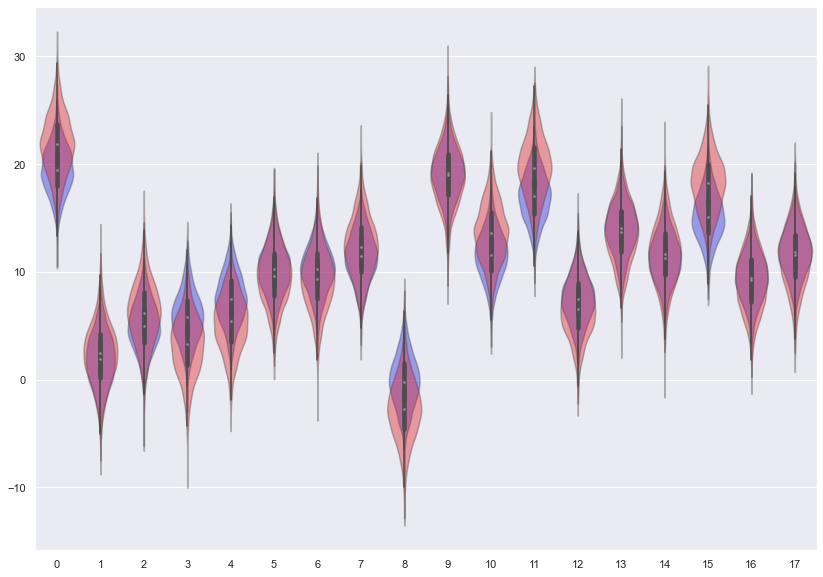

In [35]:
ax = sns.violinplot(data=d_hier, color='blue')
plt.setp(ax.collections, alpha=.4)
ax = sns.violinplot(data=d_heter, color='red')
plt.setp(ax.collections, alpha=.4);

## 17.2.9

In [36]:
beta_gen_hier = fit_hierarch.extract('beta_gen')['beta_gen']

In [37]:
beta_gen_homo = fit_homo_test.extract('beta')['beta'] 

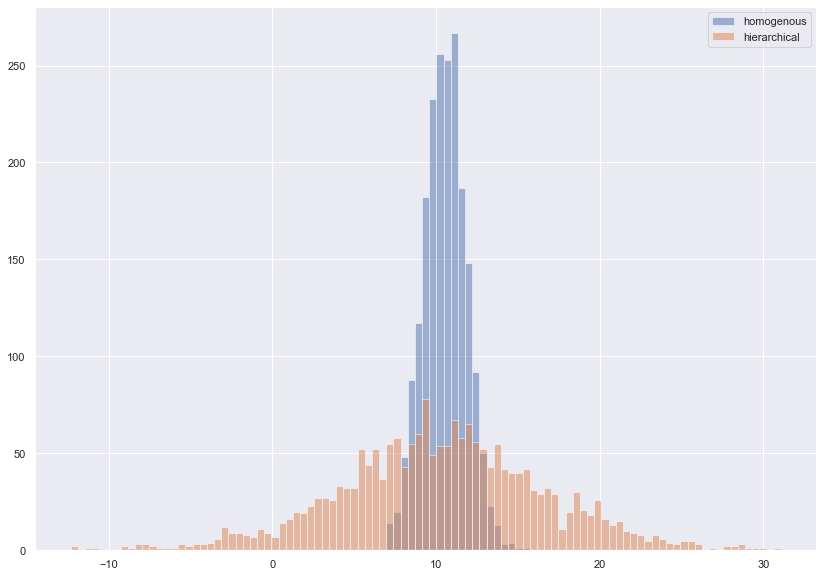

In [38]:
bins = np.linspace(min(beta_gen_hier), max(beta_gen_hier), 100)

plt.hist(beta_gen_homo, bins, alpha=0.5, label='homogenous')
plt.hist(beta_gen_hier, bins, alpha=0.5, label='hierarchical')
plt.legend();